# Algoritmo Jigsaw
En este notebook vamos a explicar las diferentes clases y métodos que utilizamos para solucionar el puzzle.

Autores: 
- Jordi Hamberg Gallego
- Héctor Sancho Rodríguez

## Clase ``Piece``:

---
```python

class Piece:
    def __init__(self, index: int):

        df = pd.read_pickle('esquinas_detectadas.pkl')

        self.index = index
        self.contour = df['contorno'][index]
        self.corners = df['esquinas'][index]

        self._sort_corners()
        self.edges = self.generate_edges()

       # Asociamos a cada pieza su imagen por delante y por detras
        back_path = "fotos/segmented_scan_25/back"
        front_path = "fotos/segmented_scan_25/front"
        self.front_img_path = f"{front_path}/{index:02d}.png"
        self.back_img_path = f"{back_path}/{index:02d}.png"

```

---
- Esta es una clase que represente cada una de las piezas del puzzle. Tiene como parámetro el índice en el que se encuentra dentro de la carpeta de fotos.

- Sus variables iniciales son los índices, los contornos y las esquinas, a partir de ello crearemos la variable que contiene las diferentes aristas con los métodos que vamos a crear. 

Ahora vamos creamos dos métodos que nos den una representación trasera y delantera, `display_back` y `display_front`, por si queremos ver la pieza con la que estamos trabajando, con las que simplemente leemos las imagenes con cv2 y las ploteamos en RGB.

---
```python

    def display_back(self):
        plt.imshow(cv.cvtColor(cv.imread(self.back_img_path), cv.COLOR_BGR2RGB))
        plt.show()

    def display_front(self):
        plt.imshow(cv.cvtColor(cv.imread(self.front_img_path), cv.COLOR_BGR2RGB))
        plt.show()
        
```
---

In [34]:
from jigsaw import Piece

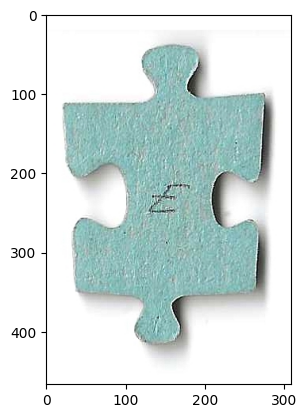

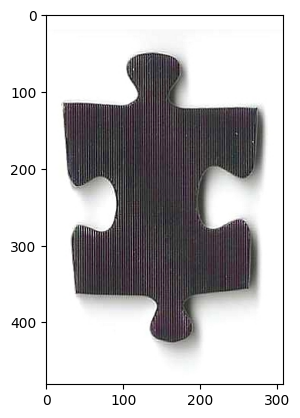

In [35]:
piece = Piece(0)
piece.display_back()
piece.display_front()

Ahora queremos tener cada arista/cara de la pieza por separado para poder hacer el algoritmo que los compare. Para conseguir las aristas necesitamos que las esquinas estén ordenadas de manera contigua para así poder recorrer el contorno, ya que ahora mismo puede que tengamos una pieza cuya lista de esquinas sea [arriba_izq, abajo_der, arriba_der, abajo_izq]. Para ello creamos un método `_sort_corners` que nos ordene en sentido horario o antihorario las piezas:

---
```python    
def _sort_corners(self):
        def angle(corner):
            centroide = np.mean(self.corners, axis=0)
            vector = corner - centroide
            return np.arctan2(vector[1], vector[0])

        self.corners = sorted(self.corners, key=angle)
```
---
Lo que hace esencialmente es calcular el vector que va desde el centroide de la pieza hasta la esquinas y ordenarlas por el ángulo que forman con respecto del eje X. Con esto conseguimos que estén ordenadas en esquinas contiguas.

Una vez tenemos esto, podemos separar cada una de las aristas con el método `generate_edges`:

---
```python
def generate_edges(self):

    edges = []

    for i in range(4):
        c2 = self.corners[i]
        c1 = self.corners[(i + 1) % 4]

        i_c1 = np.where((self.contour == c1).all(axis=1))[0][0]
        i_c2 = np.where((self.contour == c2).all(axis=1))[0][0]

        if i_c1 < i_c2:
            edge_contour = self.contour[i_c1:i_c2 + 1]
        else:
            edge_contour = np.concatenate((self.contour[i_c1:], self.contour[:i_c2 + 1]), axis=0)

        edges.append(Edge(edge_contour, self))

    return edges
```
---
Lo que hacemos con este método es simplemente coger todos los puntos del contorno que se encuentran entre las dos esquinas y guardarlas como una arista en la lista de aristas de la pieza. Cada una de las aristas es un objeto de clase Edge, que vamos a explicar ahora.

In [36]:
import pandas as pd
df = pd.read_pickle('esquinas_detectadas.pkl')
print(f'Antes de ordenar:\n {df['esquinas'][0]}')

Antes de ordenar:
 [[259 349]
 [274 100]
 [ 38 350]
 [ 22 113]]


Vemos que antes de ordenar están como [abajo_derecha, abajo_izquierda, arriba_derecha, arriba_derecha]. Al hacer el borde de abajo_izquierda a arriba_derecha, este cogería el contorno de dos aristas ya que son piezas con esquinas opuestas. Sin embargo, con _sort_corners, nos aseguramos de que estén ordenadas.

In [37]:
piece.corners

[array([ 22, 113], dtype=int32),
 array([274, 100], dtype=int32),
 array([259, 349], dtype=int32),
 array([ 38, 350], dtype=int32)]

Vemos que están [arriba_izquierda, arriba_derecha, abajo_derecha, abajo_izquierda] en el sentido de las agujas del reloj. Ahora podemos aplicar generate_edges, que como vemos nos devuelve los objetos de clase Edge (arista).

In [38]:
piece.generate_edges()

## Clase ``Edge``:

---
```python
class Edge():

    def __init__(self, contour: List[List[float, float]], pieza: Piece):
        self.contour = contour
        self.pieza = pieza
        self.kind = self.clasify_kind()  
```

---
- Esta es una clase que represente cada una de las aristas de una pieza del puzzle. Tiene como parámetros el contorno y la pieza.

- Sus variables iniciales son el contorno de la arista y la pieza a la que pertenece (objeto tipo Piece). A partir de estas variables crearemos los métodos que veamos pertinentes para solucionar el algoritmo. 

Primero creamos un método que nos den una representación trasera (porque el algoritmo lo haremos con las partes traseras de las piezas) de la arista, `plot`, por si queremos ver la arista con la que estamos trabajando. Simplemente leemos la imagen de la pieza con cv2, la ploteamos en RGB y resaltamos el contorno de la arista.

---
```python
def plot(self):
        plt.imshow(cv.cvtColor(cv.imread(self.pieza.back_img_path), cv.COLOR_BGR2RGB))
        plt.plot(self.contour[:, 0], self.contour[:, 1])
        c1 = self.contour[0]
        c2 = self.contour[-1]
        plt.plot(c1[0], c1[1], 'ro')
        plt.plot(c2[0], c2[1], 'go')
        plt.show()
```
---
Al plotear, el punto rojo representa la esquina que se encuentra en el primer ìndice del contorno y el punto verde la esquina que se encuetrna en el último índice del contorno. Aquí vemos dos ejemplos de la arista 2 (la de abajo) de la pieza 0 y la arista 0 de la pieza 5 (la de arriba).

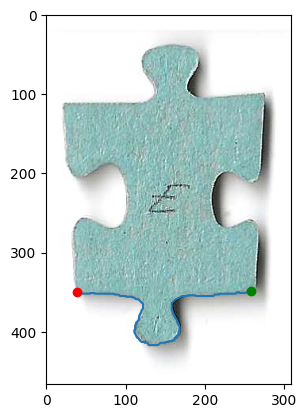

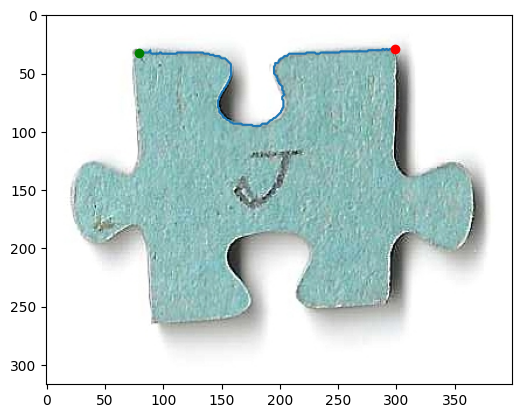

In [39]:
piece = Piece(0)
num = 2
piece.edges[num].plot()
piece = Piece(5)
num = 0
piece.edges[num].plot()

Lo siguiente que queremos hacer es comprobar el tipo al que pertenece la arista, lo haremos con la función `classify_kind`, que nos dice si se trata de una arista saliente (macho), entrante (hembra) o que forma parte del borde del puzzle (plano). Esto lo hacemos porque en el algoritmo solo querremos comparar aristas de tipo opuesto, que son las que encajarían. No tendría sentido comparar una saliente con otra saliente, en la vida real nadie lo haría.

--- 
```python
def clasify_kind(self):

        c1 = self.contour[0]
        c2 = self.contour[-1]
        
        middle_point_edge = self.contour[len(self.contour)//2]
        
        center_line = (c1 + c2) / 2
        
        vector_middle_point_to_center_line = middle_point_edge - center_line
        distance_middle_point_to_center_line = np.linalg.norm(vector_middle_point_to_center_line)
        
        if distance_middle_point_to_center_line < 5:
            return 'plano'
        
        centroide = np.mean(self.pieza.contour, axis=0)
        vector_center_line_to_centroid = centroide - center_line
        
        producto_punto = np.dot(vector_middle_point_to_center_line, vector_center_line_to_centroid)
        if producto_punto > 0:
            return 'hembra'
        else:
            return 'macho'
```
--- 
Lo que hacemos con este método es mirar el punto medio del vector que une los dos extremos y con eso hacer otros dos vectores desde ahí, uno que va hacia el punto que está en el medio del conjunto de puntos del borde; y otro que va hacia el centroide de la pieza.
Primero comprueba:
- Si la distancia entre el punto medio del vector y el punto medio del borde es menor que un umbral, lo considera como que no está lo suficientementel lejos como para ser un saliente o entrante y que se trata de una arista de tipo plano, es decir, que forma parte del borde del puzzle.

Una vez comprobado esto, seguimos teniendo dos vectores con una dirección cada uno. Los multiplicamos con un producto escalar y podemos saber de qué tipo es gracias a lo siguiente:
- Si apuntan a la misma dirección, el producto escalar será positivo y sabremos que es hembra.
- Si apuntan en distinta dirección, el producto escalar será negativo y sabremos que es macho.



Dos ejemplos:

<p style="text-align: center"><img src="fotos\ejemplos\ejemplo_arista_macho.jpg"></p>

Vemos que el vector que va desde el punto medio de la línea que une los dos extremos al punto medio del borde y el vector que va al centroide tienen dirección distinta. Por eso, será clasificado como macho.

In [40]:
piece.edges[0].kind

'hembra'

<p style="text-align: center"><img src="fotos\ejemplos\ejemplo_arista_hembra.jpg"></p>

Aquí pasa algo distinto, que el vector que va desde el punto medio de la línea que une los dos extremos al punto medio del borde y el vector que va al centroide tienen la misma dirección. Por eso, será clasificado como hembra.

In [41]:
piece= Piece(0)
piece.edges[1].kind

'hembra'

Para la pieza 0 (E) entonces la lista de tipos sería (en sentido a las agujas del reloj empezando por arriba):

In [42]:
print([edge.kind for edge in piece.edges])

['macho', 'hembra', 'macho', 'hembra']


Una vez tenemos esto vamos a hacer que el contorno de la arista esté recto con respecto al eje X, que empiece desde el punto 0 y que todas apunten hacia arriba, para más tarde poder hacer las comparaciones por similaridad/disimilaridad.
Para ellos creamos el método que tratamos como propiedad `straighten_contour`

---
```python
    @property
    def straighten_contour(self):

        c1 = self.contour[0]
        c2 = self.contour[-1]

        direction = c2 - c1
        angle = np.arctan2(direction[1], direction[0])

        kind = self.kind

        if kind == 'hembra':
            R = np.array([[np.cos(np.pi - angle), -np.sin(np.pi - angle)],
                          [np.sin(np.pi - angle),  np.cos(np.pi - angle)]])
            
            rotated = np.dot(self.contour - c2, R.T)
        else:
            R = np.array([[np.cos(-angle), -np.sin(-angle)],
                          [np.sin(-angle),  np.cos(-angle)]])
        
            rotated = np.dot(self.contour - c1, R.T)
            rotated = rotated[::-1]
        

        return rotated
```
---
Lo que hacemosa quí es mirar el ángulo que forma el vector entre las dos esquinas de la arista con el eje X y aplicar una rotación para que las dos se encuentren en el Y=0. Además restamos c2/c1 para que empiece en (0,0).

Las hembras y los machos la principio apuntaban en direcciones contrarias y se hacía como un flip horizontal, por eso los tratamos con diferentes rotaciones cada una. 

Además, al rotar los machos, el primer punto se encontraba en la esquina derecha y el último en la esquina izquierda; y al rotar las hembras el primer punto se encontraba en la esquina izquierda y el último en la esquina derecha. Esto nos traía problemas a la hora usar nuestra función de disimilaridad, ya que requiere que el orden de los puntos empiece en (0,0) para los dos. Por eso, cambiamos el orden de los puntos en los machos para que vayan también de izquierda a derecha.
  

In [43]:
piece_0_2 = Piece(0)
piece_5_0 = Piece(5)
edge_0_2 = piece_0_2.edges[2]
edge_5_0 = piece_5_0.edges[0]

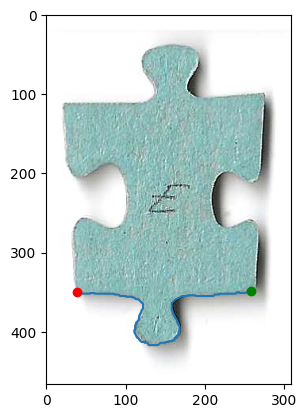

<Figure size 640x480 with 0 Axes>

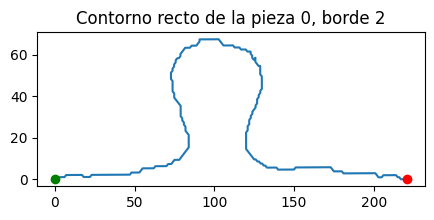

<Figure size 640x480 with 0 Axes>

In [44]:
import matplotlib.pyplot as plt
#ploteamos primero la arista 2 de la pieza 0
edge_0_2.plot()
plt.figure(figsize=(5,2))
contorno_recto_0_2 = edge_0_2.straighten_contour
plt.plot(contorno_recto_0_2[:, 0], contorno_recto_0_2[:, 1])
plt.plot(contorno_recto_0_2[0, 0], contorno_recto_0_2[0, 1], 'ro') 
plt.plot(contorno_recto_0_2[-1, 0], contorno_recto_0_2[-1, 1], 'go')
plt.title('Contorno recto de la pieza 0, borde 2')
plt.figure()

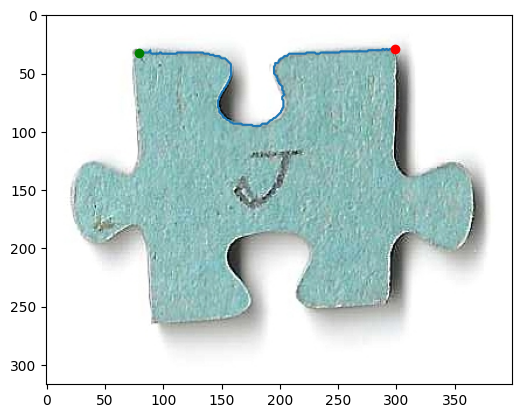

<Figure size 640x480 with 0 Axes>

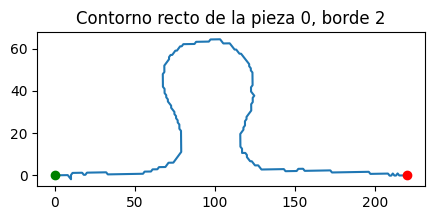

<Figure size 640x480 with 0 Axes>

In [45]:
edge_5_0.plot()
plt.figure(figsize=(5,2))
contorno_recto_5_0 = edge_5_0.straighten_contour
plt.plot(contorno_recto_5_0[:, 0], contorno_recto_5_0[:, 1])
plt.plot(contorno_recto_5_0[0, 0], contorno_recto_5_0[0, 1], 'ro') 
plt.plot(contorno_recto_5_0[-1, 0], contorno_recto_5_0[-1, 1], 'go')
plt.title('Contorno recto de la pieza 0, borde 2')
plt.figure()

Ahora teniendo las aristas rectas, ahora queremos un método que calcula la disimilaridad en el que vamos a utilizar el error cuadrático medio. Sin embargo, antes de esto, hay un problema, y es que el borde de cada arista tiene un número distinto de puntos, por lo que no sería posible utilizar ese error. Para eso creamos primero el método `resample_contour_uniform`, con el que remuestreamos el contorno de la arista de forma uniforme. Sus parámetros son: n_samples, que es el número de puntos que queremos generar a lo largo del contorno; y plot, que nos plotea el contorno original con el remuestreo que se le ha aplicado.

---
```python
def resample_contour_uniform(self, n_samples=50, plot=False):
        contour = self.straighten_contour.astype(np.float32)
        
        diffs = np.diff(contour, axis=0)
        segment_lengths = np.linalg.norm(diffs, axis=1)
        arc_lengths = np.concatenate(([0], np.cumsum(segment_lengths)))
        
        x_orig = contour[:, 0]
        y_orig = contour[:, 1]
        
        spline_x = interp1d(arc_lengths, x_orig, kind='linear')
        spline_y = interp1d(arc_lengths, y_orig, kind='linear')
        
        s_resampled = np.linspace(0, arc_lengths[-1], n_samples)
        
        x_resampled = spline_x(s_resampled)
        y_resampled = spline_y(s_resampled)

        if plot:
            plt.plot(x_orig, y_orig, '-', label='Original')
            plt.plot(x_resampled, y_resampled, 'o', label='Remuestreado', color='green')
            plt.axis('equal')
            plt.legend()
            plt.show()
        
        return x_resampled, y_resampled
```
---
Otro problema es que la densidad de puntos no es la misma según la zona del contorno, será mayor en zonas con giros y menor en zonas rectas, por lo que no podemos hacer un remuestreo de "cada x puntos elegir este punto", ya que quizás en tercer punto para una arista está en la curva y en la otra sigue en la recta. Para ello lo que hacemos es calcular el punto cada X puntos de la longitud del arco.

Lo primero que hacemos es calcular las longitudes de arco acumuladas y generar n_samples de forma uniforme a lo largo de la longitud. Luego hacemos una interpolación que dice cuál es x o y según la distancia de arco que llevo recorrida sobre el borde. Utilizamos interpolación con splines lineales y no cúbicos porque generaban oscilaciones que no representaban bien la forma del contorno. Finalmente con las interpolaciones calculamos el x e y de cada punto equiespaciado que hemos calculado con el linspace, y así conseguimos n_samples según longitud de arco.

La función devuelve los valores (x,y) de la arista resampleada.

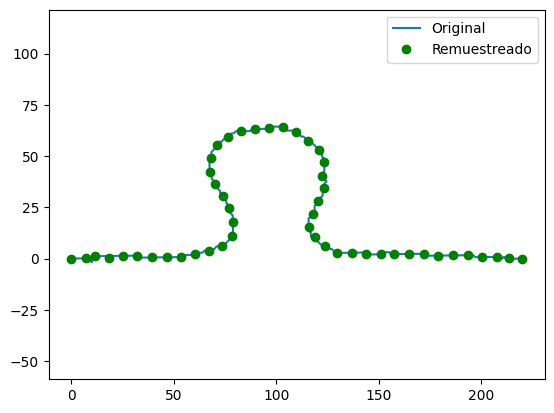

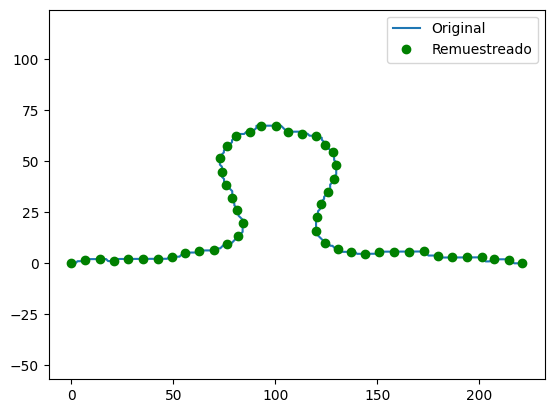

In [46]:
edge_5_0_resampled = edge_5_0.resample_contour_uniform(n_samples=50, plot=True)
edge_0_2_resampled = edge_0_2.resample_contour_uniform(n_samples=50, plot=True)

Una vez tenemos esto, vamos a a crear un método que nos mide la disimilaridad que tiene la arista actual con la de otra pieza. Lo hacemos en el método `dissimilarity`. Sus parámetros son: other, que es la otra arista con la que queremos comparar; c1, que regula la importancia que se le da en la disimialaridad a la diferencia de longitudes entre aristas (ahora se verá para qué sirve); n_samples, que nos dice cuántos samples queremos sacar con el método resample_contour_uniform; y plot, que nos plotea la disimilaridad entre las dos aristas.

--- 
```python
def dissimilarity(self, other: Edge, c1: float = 0, n_samples: int = 50, plot: Bool = False) -> float:

    if self.kind in [other.kind or 'plano']:
        return np.inf
    
    x1, y1 = self.resample_contour_uniform(n_samples=n_samples)
    x2, y2 = other.resample_contour_uniform(n_samples=n_samples)
    
    x1 = x1 - x1[0]
    y1 = y1 - y1[0]
    x2 = x2 - x2[0]
    y2 = y2 - y2[0]
    ...
```
--- 
Lo primero que hacemos es comparar si el borde de self es plano o si es del mismo tipo que el otro borde con el que está calculando la disimilaridad. En el caso de que se cumpla una de las condiciones, devuelve que la disimilaridad es infinita porque no tiene ningún sentido comparar estos pares de piezas y así en el algoritmo final no se tomará en cuenta como un posible candidato a la solución. Luego resampleamos las dos aristas para que tengan el mismo número de samples (n_samples) y los alineamos en (0,0). 

El método continúa de la siguiente manera:

--- 
```python
    ...
    best_error = np.inf
    best_tx, best_ty = 0, 0
    
    for tx in np.arange(-20, 20.5, 1):
        for ty in np.arange(-20, 20.5, 1):
            error = np.sum((x1 - (x2 + tx)) ** 2 + (y1 - (y2 + ty)) ** 2)
            if error < best_error:
                best_error = error
                best_tx, best_ty = tx, ty
    
    for tx in np.arange(best_tx - 1, best_tx + 1.1, 0.1):
        for ty in np.arange(best_ty - 1, best_ty + 1.1, 0.1):
            error = np.sum((x1 - (x2 + tx)) ** 2 + (y1 - (y2 + ty)) ** 2)
            if error < best_error:
                best_error = error
                best_tx, best_ty = tx, ty
    
    x2 = x2 + best_tx
    y2 = y2 + best_ty
    ...
```
---
Como alinear las dos en (0,0) hace que a veces aunque los bordes encajen haya uno movido un poco hacia abajo o hacia la izquierda/derecha, buscamos en un espacio de traslaciones tanto de x como de y. Primero hacemos esta búsqueda de manera amplia y luego una vez hemos encontrado la mejor solución local, refinamos un poco más con esa solución a un espacio de traslaciones más preciso todavía. Esa traslación luego la aplicamos al contorno de other y así es como mediremos la disimilaridad entre las aristas, con el mínimo error posible.

Finalmente:

---

```python
    ...
    mean_root_square_error = (np.sum((x1 - x2) ** 2 + (y1 - y2) ** 2) / n_samples) ** 0.5
    length_difference = self.abs_len_diff(other)

    dissimilarity_value = mean_root_square_error + c1 * length_difference


    if plot:
        plt.plot(x1, y1, 'o-', label='Arista 1', linewidth=2)
        plt.plot(x2, y2, 'o-', label='Arista 2', linewidth=2)
        plt.title(f'Dissimilarity: {dissimilarity_value:.2f} (tx={best_tx:.1f}, ty={best_ty:.1f})')
        plt.axis('equal')
        plt.legend()
        plt.show()

    if plot:
        for i in range(n_samples):
            plt.plot([x1[i], x2[i]], [y1[i], y2[i]], 'r-', alpha=0.3)
        plt.title('Diferencias entre puntos remuestreados')
        plt.axis('equal')
        plt.show()
    
    return dissimilarity_value
```
---
Lo último que hacemos es calcular la raíz cuadrada del error cuadrático medio de los samples de las aristas y ponderarlo también con que la distancia entre los dos extremos de cada arista sea de la misma longitud. Así aunque tengamos una arista de una pieza que por error cuadrático medio sea mejor que la que realmente debería encajar, si esta es bastante más larga o corta que la self, lo penalice y tenga más en cuenta el que tiene una longitud esquina-esquina más parecida.

La distancia entre las dos longitudes lo calculamos con dos métodos: `length` (puesto como propiedad), que calcula la longitud de solo una arista, y `abs_len_diff`, que calcula la diferencia de las longitudes de las aristas.
```python
    @property
    def length(self):
        c1 = self.contour[0]
        c2 = self.contour[-1]
        return np.linalg.norm(c2 - c1)
    
    def abs_len_diff(self, other: Edge):
        return abs(self.length - other.length)
```

Podemos ver el resultado ploteado aquí:

Miramos cuáles son las mejores candidatas por dissimilarity y ploteamos para ver cómo son:

In [47]:
from itertools import product
c1 = 0
n_samples = 30

test_edge = Piece(0).edges[2]

def disimilarity_tests(i_piece, i_edge, c1=c1, n_samples=n_samples):
    piece = Piece(i_piece)
    edge = piece.edges[i_edge]
    return test_edge.dissimilarity(edge, c1=c1, n_samples=n_samples, plot=False)

# Generar todas las combinaciones (pieza, arista)
piece_edge_combinations = list(product(range(25), range(4)))

# Ordenar por dissimilarity (de menor a mayor)
piece_edge_combinations_sorted = sorted(
    piece_edge_combinations, 
    key=lambda x: disimilarity_tests(x[0], x[1], c1=c1, n_samples=n_samples)
)

for i_piece, i_edge in piece_edge_combinations_sorted:
    disim = disimilarity_tests(i_piece, i_edge, c1=c1, n_samples=n_samples)
    print(f"Piece {i_piece} Edge {i_edge} -> Dissimilarity: {disim}")

Piece 5 Edge 0 -> Dissimilarity: 2.7773535179200985
Piece 17 Edge 2 -> Dissimilarity: 4.297369712729471
Piece 24 Edge 2 -> Dissimilarity: 6.534503164996998
Piece 19 Edge 3 -> Dissimilarity: 6.737984732107746
Piece 2 Edge 0 -> Dissimilarity: 7.442618134964471
Piece 17 Edge 0 -> Dissimilarity: 8.10010981864332
Piece 6 Edge 3 -> Dissimilarity: 8.14279520884406
Piece 9 Edge 3 -> Dissimilarity: 8.36299757803969
Piece 16 Edge 3 -> Dissimilarity: 8.467128181408988
Piece 13 Edge 0 -> Dissimilarity: 8.679857316303444
Piece 19 Edge 1 -> Dissimilarity: 9.193682768702432
Piece 12 Edge 1 -> Dissimilarity: 9.452988809470432
Piece 1 Edge 0 -> Dissimilarity: 9.546243722972822
Piece 8 Edge 0 -> Dissimilarity: 9.655879490975583
Piece 21 Edge 2 -> Dissimilarity: 10.147868096065446
Piece 18 Edge 0 -> Dissimilarity: 10.422742783117725
Piece 0 Edge 3 -> Dissimilarity: 10.513425110628534
Piece 23 Edge 0 -> Dissimilarity: 10.612949369035855
Piece 21 Edge 3 -> Dissimilarity: 10.616040132831058
Piece 16 Edge 1 

Vemos que las que son de tipo contrario tienen de valor inf. El mejor candidato para el borde 2 (el de abajo) de la pieza 0 es el borde 0 (el de arriba) de la pieza 5 (justo el que está debajo de la pieza 0), por lo que es correcto.

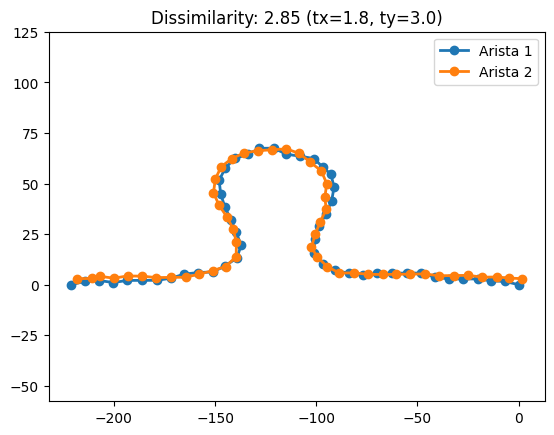

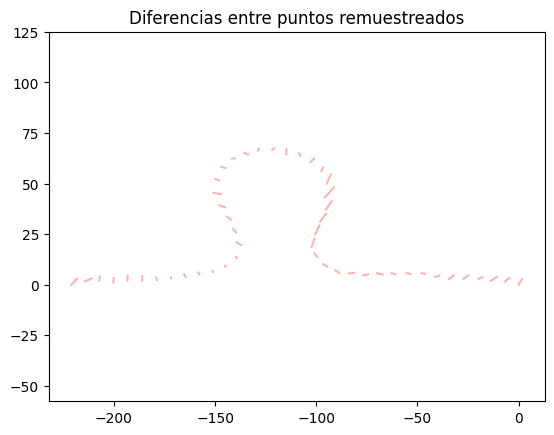

np.float64(2.84844347692704)

In [48]:
edge_0_2.dissimilarity(edge_5_0, plot=True)

Si miramos con el segundo mejor candidato (pieza 17, borde 2, es decir, el de abajo), veríamos que no encaja tan bien:

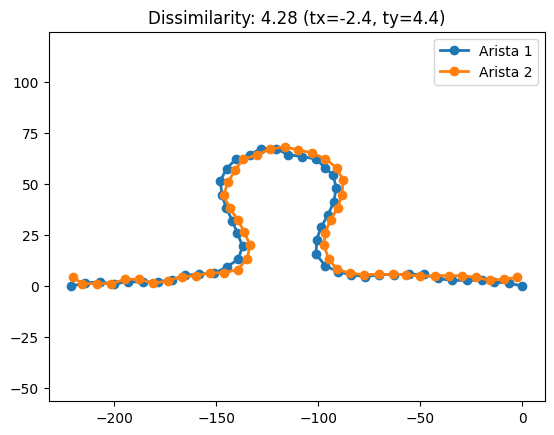

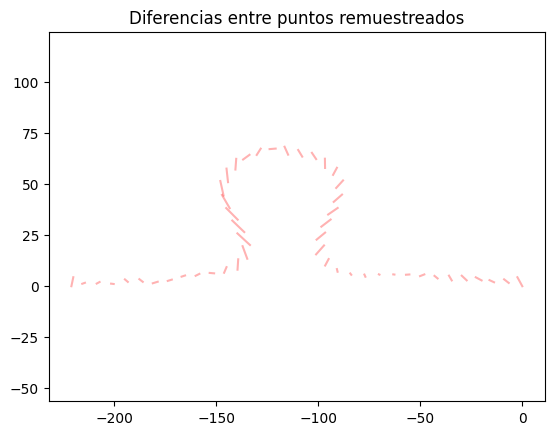

np.float64(4.279796086263769)

In [49]:
edge_0_2.dissimilarity(Piece(17).edges[2], plot=True)

## Clase ``Backtrack_solver``:

---
```python
class Backtrack_solver():
    def __init__(self, pieces: List[Piece]) -> List[Tuple[int, int]]:
        self.pieces = pieces 
```

---
- Esta es una clase que representa el algoritmo que vamos a utilizar para solucionar el problema entero y nos devuelve una lista de tuplas que vamos a explicar a continuación.

- Su variable inicial es el conjunto de piezas (objetos tipo Piece) del puzzle que vamos a utilizar para el algoritmo.

La clase solo consta de un método que contiene otras funciones anidadas. El problema lo haremos mediante backtracking.
La forma en la que queremos explorar el puzzle es con una forma en espiral, por lo que creamos una función `generate_spiral_index`.

---
```python
    def solve(self):
        def generate_spiral_index(n, m):
            result = []
            top, bottom, left, right = 0, n - 1, 0, m - 1

            while top <= bottom and left <= right:
                for j in range(left, right + 1):
                    result.append((top, j))
                top += 1

                for i in range(top, bottom + 1):
                    result.append((i, right))
                right -= 1

                if top <= bottom:
                    for j in range(right, left - 1, -1):
                        result.append((bottom, j))
                    bottom -= 1

                if left <= right:
                    for i in range(bottom, top - 1, -1):
                        result.append((i, left))
                    left += 1

            return result
        spiral_index = generate_spiral_index(5, 5)
            ...
```
---
Esta nos genera una lista de índices de una matriz n x m en orden espiral para más adelante ir iterando en el algoritmo. Como nuestro puzzle es 5x5, generamos una espiral para una matriz 5x5.

<p style="text-align: center"><img src="fotos\ejemplos\ejemplo_espiral.jpg"></p>

Nos podemos aprovechar de esta trayectoria que seguimos gracias a que una vez hemos rellenado el borde exterior, todas las demás piezas serán mucho más fáciles de encontrar ya que todas tendrán al menos dos vecinos con los que comparar aristas y será muy difícil que haya otro par de aristas de otra pieza que tenga menor disimilaridad que el par correcto.

También explicamos cómo será solución:

Va a ser una lista de tuplas (pieza_index, rotación) en orden espiral, en el que pieza_index es el índice de la pieza según su número en el path de la carpeta de imágenes, y rotación indica cuál es la arista que está arriba al resolver el algoritmo.
Así, por ejemplo la tupla (0,3) sería de la siguiente manera:
<p style="text-align: center"><img src="fotos\ejemplos\ejemplo_rotacion.jpg"></p>

Continuamos con el algoritmo:

---
```python
        ...
        start_solution = []

        for i, pieza in enumerate(self.pieces):
            edge_counter = 0

            if len(start_solution) > 0:
                break

            for rot in range(4):
                edge = pieza.edges[rot]
                if edge.kind == 'plano':
                    edge_counter += 1

                if edge_counter >= 2:
                    start_solution.append( (i, rot) )
                    break
        ...
```
---
Para la solcuión inicial queremos buscar una pieza que tenga dos bordes planos, es decir, que forme parte de una esquina, meterla en la esquina (0,0) y así empezar a mirar los mejores candidatos para su arista.

Aquí ya empezamos un algoritmo que será recursivo. La función recursiva que utilizaremos es `r_solve`, que tiene como parámetro la solución actual, será una lista de tuplas (indice, rotacion) cuya longitud indica la profundidad de la recursividad. 

Hacemos tres casos:
- longitud de solucion < 16
- longitud de solución < 25
- longitud = 25.

Empezamos con cuando la longitud < 16. Ponemos 16 porque en nuestro caso el puzzle es 5x5 y este es el número de piezas que conforma el borde del puzzle siguiendo nuestro algoritmo en espiral.
El código sería el siguiente:

---
```python
            ...
            if len(current_solution) < 16:

                next_pos = spiral_index[len(current_solution)]
                next_i, next_j = next_pos

                dif = (next_i - spiral_index[len(current_solution)-1][0], next_j - spiral_index[len(current_solution)-1][1])
                mapping_dif_to_edge_id = {
                    (0, 1): (1, 3),   # ir derecha
                    (1, 0): (2, 0),   # ir abajo: arista abajo(2) de anterior, arriba(0) de nueva
                    (0, -1): (3, 1),  # ir izquierda
                    (-1, 0): (0, 2)   # ir arriba: arista arriba(0) de anterior, abajo(2) de nueva
                }

                required_edges = mapping_dif_to_edge_id[dif]
                first_edge_id, second_edge_id = required_edges

                pares_pieza_arista_candidatos = []
                ...
```
---

Lo primero que hace es calcular la diferencia entre la posición de la pieza sobre la que estamos haciendo el algoritmo en esta profundidad y la siguiente que toca en el recorrido en espiral. Esto lo hacemos para hacer un mapeo:
- Si detecta que la diferencia es (0,1), significa que la siguiente pieza está a la derecha, por lo que tiene que encajar la arista 1 de la arista actual (ya rotada con la orientación de la solución) con la arista x de la siguiente (también rotada para que la arista x se convierta en la arista 3 con la nueva orientación). Así es igual con todos los mappings.

<p style="text-align: center"><img src="fotos\ejemplos\ejemplo_mapping.jpg"></p>

Luego:

---
```python
                ...
                for pieza_index, pieza in enumerate(self.pieces):

                    if pieza_index in [s[0] for s in current_solution]:
                        continue  # ya usada


                    is_edge = False
                    for rot in range(4):
                        edge = pieza.edges[rot]
                        if edge.kind == 'plano':
                            is_edge = True
                    if not is_edge:
                        continue


                    for rot in range(4):
                        edge = pieza.edges[rot]
                        if edge.kind != 'plano':
                            pares_pieza_arista_candidatos.append( (pieza_index, rot) )
                ...
```
---

Esto mira todas las piezas no usadas que formen parte del borde (porque primero estamos comprobando el exterior) y pone como candidatas todas sus aristas no planas con su rotación pertinente para que estén en la posición para que encajen.

Ahora calculamos todas las disimilaridades y las ordenamos por los mejores candidatos: 

---
```python
                ...
                def dissimilarity_key(id_pieza, edge_id):
                    return self.pieces[id_pieza].edges[edge_id].dissimilarity(

                        self.pieces[current_solution[-1][0]].edges[
                            (current_solution[-1][1] + first_edge_id) % 4
                        ], c1=c1, n_samples=n_samples, plot=False
                    )
                
                pares_pieza_arista_candidatos = sorted(
                    pares_pieza_arista_candidatos,
                    key=lambda x: dissimilarity_key(x[0], x[1])
                )
                ...
```
---

Una vez lo tenemos ordenado creamos el caso base de la recursión:

---
```python
                ...
                if self.pieces[current_solution[-1][0]].edges[
                    (current_solution[-1][1] + first_edge_id) % 4
                ].dissimilarity(
                    self.pieces[pares_pieza_arista_candidatos[0][0]].edges[
                        pares_pieza_arista_candidatos[0][1]
                    ], c1=c1, n_samples=n_samples, plot=False
                ) > edge_threshold:
                    if not greedy:
                        return None
                ...
```
---

Lo que hace esto es comprobar si el mejor candidato supera un umbral de disimilaridad. Si supera ese umbral, significa que son muy diferentes y que al ser ese el mejor candidado posible ha habido otro paso anterior en el que nos hemos equivocado, por lo que sube un nivel en la profundidad de recursividad y va al siguiente candidato.
Por ejemplo:
<p style="text-align: center"><img src="fotos\ejemplos\ejemplo_recursividad.jpg"></p>

Como ha superado la disimilaridad umbral, tacha todos esos y se va al siguiente candidato en el anterior nivel:

<p style="text-align: center"><img src="fotos\ejemplos\ejemplo_recursividad_2.jpg"></p>

Y así sigue explorando con el siguiente código:

---
```python
                for pieza_index, edge_id in pares_pieza_arista_candidatos:
                    # Probamos a añadir la pieza a la solucion
                    new_solution = current_solution + [ (pieza_index, (edge_id - second_edge_id) % 4) ]

                    # Llamamos recursivamente
                    result = r_solve(new_solution)
                    if result is not None:
                        return result
```
---

Y así hasta que llegamos a la profundidad 15. Una vez llegamos ahí seguimos con el siguiente código, que es mirando los del interior hasta que llegan a longitud 25, que sería ya el puzzle terminado.

---
```python
            ... 
            elif len(current_solution) < 25:
                next_pos = spiral_index[len(current_solution)]
                next_i, next_j = next_pos
                pos_to_spiral_idx = {pos: idx for idx, pos in enumerate(spiral_index)}

                vecinos_resueltos = []
                for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    vecino_pos = (next_i + di, next_j + dj)
                    if vecino_pos in pos_to_spiral_idx:
                        vecino_spiral_idx = pos_to_spiral_idx[vecino_pos]
                        if vecino_spiral_idx < len(current_solution):
                            vecinos_resueltos.append((vecino_spiral_idx, (di, dj)))

                pares_pieza_arista_candidatos = []

                for pieza_index, pieza in enumerate(self.pieces):

                    if pieza_index in [s[0] for s in current_solution]:
                        continue

                    has_flat_edge = False
                    for rot in range(4):
                        edge = pieza.edges[rot]
                        if edge.kind == 'plano':
                            has_flat_edge = True
                            break
                    if has_flat_edge:
                        continue

                    for rot in range(4):
                        pares_pieza_arista_candidatos.append((pieza_index, rot))
                ...
```
---
Lo primero que hace es crear un diccionario que mapea posición a índice en la espiral para buscar los vecinos.

Entonces encuentra todos los vecinos adyacentes que ya están en la solución mirando en las cuatro direcciones y lo guarda en una lista de vecinos. 

Luego busca nuevamente los candidatos, esta vez descartando los que tienen borde plano porque estamos en el interior del puzzle ya, no queremos usar como candidatos piezas del exterior. En este caso añadimos como posibles candidatos las 4 rotaciones posibles porque ninguna de las aristas es plana.

Luego ordena los candidatos por disimilaridad total que tiene con todos los vecinos:
 
---
```python
                ... 
                def dissimilarity_key_interior(id_pieza, rotacion_candidato):
                    total_dissimilarity = 0
                    
                    for vecino_spiral_idx, direccion in vecinos_resueltos:
                        # Obtener la pieza vecina y su rotación
                        vecino_pieza_idx, vecino_rotacion = current_solution[vecino_spiral_idx]
                        
                        # Obtener qué aristas conectan según la dirección
                        arista_pos_candidato, arista_pos_vecino = direction_to_edges[direccion]
                        
                        arista_candidato = (arista_pos_candidato + rotacion_candidato) % 4
                        
                        # Calcular la arista original del vecino que está en esa posición
                        arista_vecino = (arista_pos_vecino + vecino_rotacion) % 4
                        
                        # Calcular disimilaridad entre estas aristas
                        dissim = self.pieces[id_pieza].edges[arista_candidato].dissimilarity(
                            self.pieces[vecino_pieza_idx].edges[arista_vecino],
                            c1=c1, n_samples=n_samples, plot=False
                        )
                        total_dissimilarity += dissim
                    
                    return total_dissimilarity
                
                pares_pieza_arista_candidatos = sorted(
                    pares_pieza_arista_candidatos,
                    key=lambda x: dissimilarity_key_interior(x[0], x[1])
                )
                ...
```
---

Para saber las aristas que tienen que evaluarse para la disimilaridad miramos la arista en la dirección que se supone que encajan con el mapping y con las rotaciones que se le han aplicado a la pieza. Así si por ejemplo estamos subiendo en la espiral, tnemos que mirar la arista 2 de la pieza que quizás se ha rotado 3 veces (en sentido antihorario). Entonces realmente estaríamos mirando la arista 2+3 = 5 % 4 = 1.
Así con cada vecino y conseguimos la suma de las disimilaridades contodos los vecinos.

Ordenamos los candidatos y continuamos de la siguiente manera:

---
```python
                ... 
                if len(pares_pieza_arista_candidatos) == 0:
                    return None

                best_dissimilarity = dissimilarity_key_interior(
                    pares_pieza_arista_candidatos[0][0],
                    pares_pieza_arista_candidatos[0][1]
                )
                
                umbral_por_vecino = interior_threshold
                if best_dissimilarity > umbral_por_vecino * len(vecinos_resueltos):
                    if not greedy:
                        return None

                for pieza_index, rotacion in pares_pieza_arista_candidatos:
                    new_solution = current_solution + [(pieza_index, rotacion)]

                    result = r_solve(new_solution)
                    if result is not None:
                        return result
                return None 

            if len(current_solution) == 25:
                return current_solution
            return None

        return r_solve(start_solution)
```
---

Si no hay candidatos, hace como un segundo caso base en el que también retorna None y retrocede. Luego si el mejor candidato supera un umbral (multiplicado por el número de vecinos que tenemos ya que el umbral es por arista) también volvemos atrás un nivel.

Luego llamamos recursivamente nuevamente. Si mientras hacemos el bucle hasta los 25 nos quedamos sin candidatos que mirar, volvemos atrás también.

Si no llega nunca a 25 y devuelve None, significa que hay que ajustar parámetros o mejorar el procesamiento de las imágenes.

Cuando llega a 25 de longitud significa que el puzzle está terminado y nos devuelve la solución.

<p style="color:red"><strong>Para ver cómo funciona el algoritmo con los ejemplos y plots, ir a solution_plot_test.ipynb</strong></p>